#Imports and data download

In [ ]:
from tqdm import tqdm
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from matplotlib import pyplot as plt
!wget https://data.deepai.org/conll2003.zip
!unzip ./conll2003.zip
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

--2021-11-04 07:17:52--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/x-zip-compressed]
Saving to: ‘conll2003.zip’

conll2003.zip       100%[===================>] 959.94K  1.87MB/s    in 0.5s    

2021-11-04 07:17:53 (1.87 MB/s) - ‘conll2003.zip’ saved [982975/982975]

Archive:  ./conll2003.zip
  inflating: metadata                
  inflating: test.txt                
  inflating: train.txt               
  inflating: valid.txt               
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
with open('train.txt') as f:
  train_text_data = f.readlines()
print('train' , len(train_text_data)) 
# print(len(train_text_data)) 
with open('test.txt') as g:
  test_data = g.readlines()
print('test',len(test_data))

with open('valid.txt') as h:
  valin_data = h.readlines()
print('valdn',len(valin_data))

train 219554
test 50350
valdn 55044


#DATA PREPROCESSING

In [ ]:
def senNametag(fileName):     #sentence_NE_tagger
  with open(fileName) as f:
    lines=f.readlines()
  sentence=[]
  data_loader=[]

  for i,word in enumerate(lines):
    if word.startswith('-DOCSTART-') or word[0]=='\n':
      data_loader.append(sentence)
      sentence=[]
      continue
    word_seq=word.split(' ')
    sentence.append([word_seq[0],word_seq[1],word_seq[2],1 if word_seq[3].strip()!='O' else 0])

  if len(sentence)>0:
     data_loader.append(sentence) 

  data_loader=[x for x in data_loader if x]
  return data_loader
  
train_loader = senNametag('train.txt')
valid_loader = senNametag('valid.txt')
test_loader = senNametag('test.txt')

In [ ]:
# len(train_loader[0])

In [ ]:
train_loader[2]

[['BRUSSELS', 'NNP', 'B-NP', 1], ['1996-08-22', 'CD', 'I-NP', 0]]

In [ ]:
total,n_NE_words,n_nonNE_words=0,0,0
for i in range(len(train_loader)):
  for j in range(len(train_loader[i])):
    total=total+1
    if(train_loader[i][j][-1]==1):
        n_NE_words+=1
    if(train_loader[i][j][-1]==0):
        n_nonNE_words+=1

# print(f'number of train sentence: {len(train_loader)}')
# print(f'Number of NE words:{n_NE_words},number of non NE words {n_nonNE_words}')

In [ ]:
POS_tags = set(map(lambda x:x[0][2][::-1].split('-')[0][::-1], train_loader))
POS_tags

{'ADJP', 'ADVP', 'CONJP', 'INTJ', 'LST', 'NP', 'O', 'PP', 'PRT', 'SBAR', 'VP'}

In [ ]:
def wordFeat(i,sent,pos_no):        #wordToFeatures
  word=sent[i][0]
  pos_tag=sent[i][2]

  word_features={
      'length':len(word),
      'tag_POS':pos_no[pos_tag[::-1].split('-')[0][::-1]],
      'tag_prev_pos':pos_no[sent[max(i-1,0)][2][::-1].split('-')[0][::-1]],
      'tag_next_pos': pos_no[sent[min(i+1,len(sent)-1)][2][::-1].split('-')[0][::-1]],
      'First_not_Captial': 1 if (i!=0 and word[0].isupper()) else 0,
      'All_capital_letters': 1 if word.isupper() else 0
  }
  return word_features

In [ ]:
def sentFeat(sent,pos_no):        #sentenceToFeatures
  return [wordFeat(i,sent,pos_no) for i in range(len(sent))]

def senLab(sentence):         #sentenceToLabels
  return list(map(lambda x:x[-1],sentence))

def posToNum():
  pos_to_numLabels={x[1]:x[0] for x in list(enumerate(sorted(set(map(lambda x:x[0][2][::-1].split('-')[0][::-1], train_loader)))))}
  return pos_to_numLabels
pos_to_num=posToNum()

In [ ]:
pos_to_num

{'ADJP': 0,
 'ADVP': 1,
 'CONJP': 2,
 'INTJ': 3,
 'LST': 4,
 'NP': 5,
 'O': 6,
 'PP': 7,
 'PRT': 8,
 'SBAR': 9,
 'VP': 10}

In [ ]:
train_features,valid_features=[],[]
train_labels,valid_labels=[],[]
pos_as_num=posToNum()
for i in tqdm(range(len(train_loader))):
    train_features.append(sentFeat(train_loader[i],pos_as_num))
    train_labels.append(senLab(train_loader[i]))

for i in tqdm(range(len(valid_loader))):
    valid_features.append(sentFeat(valid_loader[i],pos_as_num))
    valid_labels.append(senLab(valid_loader[i]))

100%|██████████| 3250/3250 [00:00<00:00, 16393.34it/s]


In [ ]:
train_features[10]

[{'All_capital_letters': 0,
  'First_not_Captial': 0,
  'length': 7,
  'tag_POS': 5,
  'tag_next_pos': 5,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 1,
  'length': 4,
  'tag_POS': 5,
  'tag_next_pos': 5,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 1,
  'length': 8,
  'tag_POS': 5,
  'tag_next_pos': 5,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 1,
  'length': 6,
  'tag_POS': 5,
  'tag_next_pos': 5,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 0,
  'length': 2,
  'tag_POS': 5,
  'tag_next_pos': 5,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 1,
  'length': 7,
  'tag_POS': 5,
  'tag_next_pos': 10,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 0,
  'length': 3,
  'tag_POS': 10,
  'tag_next_pos': 10,
  'tag_prev_pos': 5},
 {'All_capital_letters': 0,
  'First_not_Captial': 0,
  'length': 7,
  'tag_POS': 10,
  'tag_next_pos

In [ ]:
dict_vec=DictVectorizer()
X_train=np.concatenate(np.array([dict_vec.fit_transform(x).toarray() for x in train_features]))
Y_train=np.concatenate(np.array(train_labels))
X_val=np.concatenate(np.array([dict_vec.fit_transform(x).toarray() for x in valid_features]))
Y_val=np.concatenate(np.array(valid_labels))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

In [ ]:
print(f'training data shape :{X_train.shape} actual training output shape :{Y_train.shape}')
print(f'validation data shape :{X_val.shape} actual validation output shape :{Y_val.shape}')

training data shape :(203621, 6) actual training output shape :(203621,)
validation data shape :(51362, 6) actual validation output shape :(51362,)


#SVM classifier

In [ ]:
SVM=svm.SVC(C=1.0,kernel='linear',degree=3 ,gamma='auto',verbose=True)
SVM.fit(X_train,Y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [ ]:
y_pred=SVM.predict(X_val)
accuracy=accuracy_score(y_pred,Y_val)
# print(len(y_pred),len(Y_val))


#Confusion matrix and all the parameters calculation

In [ ]:
conf_mat=confusion_matrix(y_pred,Y_val)
precision=np.zeros(conf_mat.shape[0])
recall=np.zeros(conf_mat.shape[0])
acc=0
for i in range(conf_mat.shape[0]):
  if conf_mat.sum(axis=0)[i] !=0:
    precision[i]=conf_mat[i][i]/conf_mat.sum(axis=0)[i]
    recall[i]=conf_mat[i][i]/conf_mat.sum(axis=1)[i]
    acc+=conf_mat

acc=acc/sum(sum(conf_mat))
total_precision=sum(precision)/len(precision)
total_recall=sum(recall)/len(recall)
f1_score=(2*total_precision*total_recall)/(total_precision+total_recall)
# f_0.5_score=(1.25*total_precision*total_recall)/(0.25*total_precision+total_recall)
f2_score=(5*total_precision*total_recall)/(4*total_precision+total_recall)

0.8194969043261555 C=1.0,kernel='sigmoid',degree=6 ,gamma='auto',verbose=True \\
0.9397219734434017 C=1.0,kernel='linear',degree=3 ,gamma='auto',verbose=True

SVMcoef_ [[-1.53477231e-12  2.00002167e+00  3.40489879e-06  1.20693851e-05
   1.11557097e-06 -2.58478802e-05]]
accuracy is : 0.9397219734434017
precision:  0.8912799706500112
recall :  0.8923007281100408
f1 score:  0.891790057286208
f2 score :  0.8920963896137768
confusion matrix [[41225  1562]
 [ 1534  7041]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


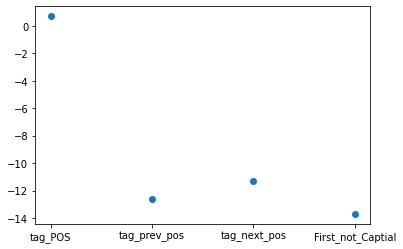

In [ ]:
print("SVMcoef_",SVM.coef_)
print('accuracy is :',accuracy)
print('precision: ', total_precision)
print('recall : ',total_recall)
print('f1 score: ', f1_score)
print('f2 score : ',f2_score)
print('confusion matrix',conf_mat)
x = ['length','tag_POS','tag_prev_pos','tag_next_pos','First_not_Captial','All_capital_letters']
x1 = np.array(x)
y = np.log(SVM.coef_)
plt.scatter(x1,y)

In [ ]:
valid_loader[1]

[['LONDON', 'NNP', 'B-NP', 1], ['1996-08-30', 'CD', 'I-NP', 0]]

In [ ]:
valid_labels[1]

[1, 0]

In [ ]:
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
sent1 = 'The State Bank of India is the largest bank in the country'
sent2 = 'Pushpak Bhattacharyya teaches us CS626'
sent3 = 'India got its freedom on 15th August 1947'
# sent4 = 'India got its freedom on 15-8-1947'
# sent5 = 'India got its freedom on 15/8/1947'
# sent6 = 'India got its freedom on 15.8.1947'

In [ ]:
text = sent1.split()
text

['The',
 'State',
 'Bank',
 'of',
 'India',
 'is',
 'the',
 'largest',
 'bank',
 'in',
 'the',
 'country']

In [ ]:
tokens_tag = pos_tag(text)
tokens_tag

[('The', 'DT'),
 ('State', 'NNP'),
 ('Bank', 'NNP'),
 ('of', 'IN'),
 ('India', 'NNP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('largest', 'JJS'),
 ('bank', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('country', 'NN')]

In [ ]:
def custom_sents2features(sent):
  if isinstance(sent,str):
    print("instance is str")
    sent = sent.strip().split(' ')
  elif isinstance(sent,list):
    pass
  else:
    raise ValueError("Input sentence must be in list of words format or string format")
  # print(sent)
  # print(len(sent))
  return [noPOS_word2features(sent, i) for i in range(len(sent))]

In [ ]:
vec = DictVectorizer()
custom_feats = custom_sents2features(text)
X_custom_test = np.concatenate(np.array([vec.fit_transform(x).toarray() for x in custom_feats]))

NameError: ignored

In [ ]:
custom_tags

In [ ]:
def numbers_to_strings(argument):
    switcher = {
        'ADJ': 0,
        'ADV':1,
        'CONJ':2,
        'NOUN':5,
        'DET'
        'PRON':7,
        'PRT': 8,
        'VERB':10
        


    }
    {'ADJP': 0,
 'ADVP': 1,
 'CONJP': 2,
 'INTJ': 3,
 'LST': 4,
 'NP': 5,
 'O': 6,
 'PP': 7,
 'PRT': 8,
 'SBAR': 9,
 'VP': 10}

 [('John', 'NOUN'), ("'s", 'PRT'), ('big', 'ADJ'), ('idea', 'NOUN'), ('is', 'VERB'),
("n't", 'ADV'), ('all', 'DET'), ('that', 'DET'), ('bad', 'ADJ'), ('.', '.')]